# Import Necessary Libraries 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('E:\\TFRS\\'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# Any results you write to the current directory are saved as output.

"\nimport os\nfor dirname, _, filenames in os.walk('E:\\TFRS\\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# Importing the Dataset

## Read and Explore the Data

In [2]:
#Import the data set
df = pd.read_csv('Reviews.csv')


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# Dropping the columns
df = df.drop(['Id', 'ProfileName','Time','HelpfulnessNumerator','HelpfulnessDenominator','Text','Summary'], axis = 1) 


In [5]:
# see few rows of the imported dataset
df.tail()

,ProductId,UserId,Score
568449,B001EO7N10,A28KG5XORO54AY,5
568450,B003S1WTCU,A3I8AFVPEE8KI5,2
568451,B004I613EE,A121AA1GQV751Z,5
568452,B004I613EE,A3IBEVCTXKNOH,5
568453,B001LR2CU2,A3LGQPJCZVL9UC,5


In [6]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  568454
No of columns:  3


In [7]:
#Check Data types
df.dtypes

ProductId    object
UserId       object
Score         int64
dtype: object

In [8]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 ProductId    0
UserId       0
Score        0
dtype: int64


### There are no missing values with total records 568454


In [9]:
# Summary statistics of 'rating' variable
df[['Score']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Score,568454.0,4.183199,1.310436,1.0,4.0,5.0,5.0,5.0


In [10]:
# find minimum and maximum ratings 

def find_min_max_rating():
    print('The minimum rating is: %d' %(df['Score'].min()))
    print('The maximum rating is: %d' %(df['Score'].max()))
    
find_min_max_rating() 

The minimum rating is: 1
The maximum rating is: 5


### Ratings are on scale of 1 - 5


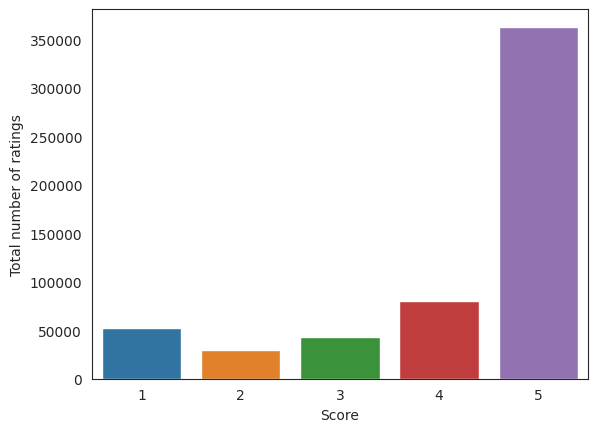

In [11]:
# Check the distribution of ratings
with sns.axes_style('white'):
    g = sns.countplot(data=df, x="Score")
    g.set_ylabel("Total number of ratings")


In [12]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['UserId'].nunique())
print('Number of unique ITEMS in Raw data = ', df['ProductId'].nunique())

Number of unique USERS in Raw data =  256059
Number of unique ITEMS in Raw data =  74258


### Take subset of dataset to make it less sparse/more dense. ( For example, keep the users only who has given 50 or more number of ratings )

In [13]:
# Top 10 users based on rating
most_rated = df.groupby('UserId').size().sort_values(ascending=False)[:5]
most_rated

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
dtype: int64

### Data model preparation as per requirement on number of minimum ratings


In [14]:
counts = df['UserId'].value_counts()
df_final = df[df['UserId'].isin(counts[counts >= 50].index)]

In [15]:
counts

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
                 ... 
A2O8OFVSTO9PF3      1
A1C6KXG47GAQ7B      1
A1TU5DS89D9OVD      1
A3N005JS5FG5FI      1
A3LGQPJCZVL9UC      1
Name: count, Length: 256059, dtype: int64

In [16]:
df_final.head()

,ProductId,UserId,Score
14,B001GVISJM,A2MUGFV2TDQ47K,5
44,B001EO5QW8,A2G7B7FKP2O2PU,5
46,B001EO5QW8,AQLL2R1PPR46X,5
109,B001REEG6C,AY12DBB0U420B,5
141,B001GVISJW,A2YIO225BTKVPU,4


In [17]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['UserId'].nunique())
print('Number of unique ITEMS in final data = ', df_final['ProductId'].nunique())

Number of users who have rated 50 or more items = 22941
Number of unique USERS in final data =  267
Number of unique ITEMS in final data =  11313


#### df_final has users  who have rated 50 or more items

#### Calculate the density of the rating matrix

In [18]:

final_ratings_matrix = pd.pivot_table(df_final,index=['UserId'], columns = 'ProductId', values = "Score")
final_ratings_matrix.fillna(0,inplace=True)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (267, 11313)
given_num_of_ratings =  20829
possible_num_of_ratings =  3020571
density: 0.69%


In [19]:
final_ratings_matrix.tail()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,
AY1EF0GOH80EK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYB4ELCS5AM8P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYGJ96W5KQMUJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYOMAHLWRQHUG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZV26LP92E6WU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

UserId,A100WO06OQR8BQ,A106ZCP7RSXMRU,A1080SE9X3ECK0,A10G136JEISLVR,A11ED8O95W2103,A11OTLEDSW8ZXD,A12ENBT314RFXR,A132ETQPMHQ585,A13GZCHAMKWYBT,A13HRSMJ5TOWEZ,...,ATJN4KEHJBOC8,AVFA1JB08RG8G,AWKZAUC0D8DYL,AXO4PQU0XG3TG,AY12DBB0U420B,AY1EF0GOH80EK,AYB4ELCS5AM8P,AYGJ96W5KQMUJ,AYOMAHLWRQHUG,AZV26LP92E6WU
ProductId,,,,,,,,,,,,,,,,,,,,,
7310172001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7310172101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7800648702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004CI84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
B00004CXX9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


### Split the data randomly into train and test dataset. ( For example split it in 70/30 ratio)

#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)

print(train_data.head(5))

def shape():
    print("Test data shape: ", test_data.shape)
    print("Train data shape: ", train_data.shape)
shape() 

In [ ]:
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Score'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df['User ID'], df['Score'], test_size=0.1, random_state=42)

#TOKENIZE DATA
tokenizer = Tokenizer(num_words=5000)  # Limit the vocabulary size
tokenizer.fit_on_texts(train_data)

true_train = tokenizer.texts_to_sequences(train_data)
true_test = tokenizer.texts_to_sequences(test_data)

vocab_size = len(tokenizer.word_index) + 1
max_length = 100  # Define the maximum sequence length

true_train = pad_sequences(true_train, maxlen=max_length, padding='post')
true_test = pad_sequences(true_test, maxlen=max_length, padding='post')
'''
# Encode the target variable
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
'''

In [22]:
#PREDICTED SCORE
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Dense, concatenate
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
train_data, test_data = train_test_split(df_final, test_size=0.3, random_state=0)

# Create a dictionary mapping user IDs to unique indices
user_ids = df_final['UserId'].unique()
user_id_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
index_to_user_id = {index: user_id for index, user_id in enumerate(user_ids)}

# Create a dictionary mapping product IDs to unique indices
product_ids = df_final['ProductId'].unique()
product_id_to_index = {product_id: index for index, product_id in enumerate(product_ids)}
index_to_product_id = {index: product_id for index, product_id in enumerate(product_ids)}

# Convert user and product IDs to indices in the dataframe
train_data['user_index'] = train_data['UserId'].map(user_id_to_index)
train_data['product_index'] = train_data['ProductId'].map(product_id_to_index)

test_data['user_index'] = test_data['UserId'].map(user_id_to_index)
test_data['product_index'] = test_data['ProductId'].map(product_id_to_index)

# Prepare the training data
x_train = train_data[['user_index', 'product_index']].values
x1_train = train_data[['user_index']].values
x2_train = train_data[['product_index']].values
y_train = train_data['Score'].values
y_train = np.reshape(y_train, (-1, 1))

# Set the input shape
num_users = len(user_ids)+1
num_products = len(product_ids)+1
input_shape = 2  # User index and product index

# Create separate embedding layers for each input
embedding1 = tf.keras.layers.Embedding(num_users, output_dim=64)(x1_train)
embedding2 = tf.keras.layers.Embedding(num_products, output_dim=64)(x2_train)

# Flatten the embeddings
flatten1 = tf.keras.layers.Flatten()(embedding1)
flatten2 = tf.keras.layers.Flatten()(embedding2)

# Flatten the embeddings
flatten1 = tf.keras.layers.Flatten()(embedding1)
flatten2 = tf.keras.layers.Flatten()(embedding2)

# Merge the flattened embeddings
merged = tf.keras.layers.concatenate([flatten1, flatten2])

# Define the output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

# Define the output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

# Create the model
model = Sequential()
model.add(output)

# Compile and train the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=32)

'''
# Define the model
model = Sequential([
    Embedding(num_users, 32, input_length=input_shape)(train_data[['user_index']]),
    Flatten(),
    Embedding(num_products, 32, input_length=input_shape)(train_data[['product_index']]),
    Flatten(),
    concatenate(),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='mean_squared_error', optimizer='adam')

    
# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)
'''
# Prepare the test data
x_test = test_data[['user_index', 'product_index']].values

# Predict the ratings for all user-product combinations
ratings = model.predict(x_test)

# Convert the predicted ratings to a DataFrame
predicted_ratings_df = pd.DataFrame({
    'UserId': test_data['UserId'],
    'ProductId': test_data['ProductId'],
    'PredictedRating': ratings.flatten()
})

# Example: Get predicted ratings for a specific user ID
user_id = 2
user_id_index = user_id_to_index[user_id]
predicted_ratings_for_user = predicted_ratings_df[predicted_ratings_df['UserId'] == user_id]

print(predicted_ratings_for_user)


TypeError: The added layer must be an instance of class Layer. Received: layer=[[0.4979117 ]
 [0.477599  ]
 [0.510062  ]
 ...
 [0.5037362 ]
 [0.49215853]
 [0.51175785]] of type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [ ]:
#PREDICTED SCORE
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Dense, concatenate
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
train_data, test_data = train_test_split(df_final, test_size=0.3, random_state=0)

# Create a dictionary mapping user IDs to unique indices
user_ids = df_final['UserId'].unique()
user_id_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
index_to_user_id = {index: user_id for index, user_id in enumerate(user_ids)}

# Create a dictionary mapping product IDs to unique indices
product_ids = df_final['ProductId'].unique()
product_id_to_index = {product_id: index for index, product_id in enumerate(product_ids)}
index_to_product_id = {index: product_id for index, product_id in enumerate(product_ids)}

# Convert user and product IDs to indices in the dataframe
train_data['user_index'] = train_data['UserId'].map(user_id_to_index)
train_data['product_index'] = train_data['ProductId'].map(product_id_to_index)

test_data['user_index'] = test_data['UserId'].map(user_id_to_index)
test_data['product_index'] = test_data['ProductId'].map(product_id_to_index)

# Prepare the training data
x_train = train_data[['user_index', 'product_index']].values
x1_train = train_data[['user_index']].values
x2_train = train_data[['product_index']].values
y_train = train_data['Score'].values
y_train = np.reshape(y_train, (-1, 1))

# Set the input shape
num_users = len(user_ids)+1
num_products = len(product_ids)+1
input_shape = 2  # User index and product index

# Create separate embedding layers for each input
embedding1 = tf.keras.layers.Embedding(num_users, output_dim=64)(x1_train)
embedding2 = tf.keras.layers.Embedding(num_products, output_dim=64)(x2_train)

# Flatten the embeddings
flatten1 = tf.keras.layers.Flatten()(embedding1)
flatten2 = tf.keras.layers.Flatten()(embedding2)

# Flatten the embeddings
flatten1 = tf.keras.layers.Flatten()(embedding1)
flatten2 = tf.keras.layers.Flatten()(embedding2)

# Merge the flattened embeddings
merged = tf.keras.layers.concatenate([flatten1, flatten2])

# Define the output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

# Define the output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

# Compile and train the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=32)

# Prepare the test data
x_test = test_data[['user_index', 'product_index']].values

# Predict the ratings for all user-product combinations
ratings = model.predict(x_test)

# Convert the predicted ratings to a DataFrame
predicted_ratings_df = pd.DataFrame({
    'UserId': test_data['UserId'],
    'ProductId': test_data['ProductId'],
    'PredictedRating': ratings.flatten()
})

# Example: Get predicted ratings for a specific user ID
user_id = 2
user_id_index = user_id_to_index[user_id]
predicted_ratings_for_user = predicted_ratings_df[predicted_ratings_df['UserId'] == user_id]

print(predicted_ratings_for_user)


In [ ]:
train_data['user_index']

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense,GlobalAveragePooling1D

# Convert UserId and ProductId to numerical values
user_ids = df_final['UserId'].unique()
user_id_to_index = {id_: index for index, id_ in enumerate(user_ids)}
df_final['UserId'] = df_final['UserId'].map(user_id_to_index)

product_ids = df_final['ProductId'].unique()
product_id_to_index = {id_: index for index, id_ in enumerate(product_ids)}
df_final['ProductId'] = df_final['ProductId'].map(product_id_to_index)

# Split the data
train_data, test_data = train_test_split(df_final, test_size=0.3, random_state=0)

# Define the vocabulary size and embedding dimension
vocab_size = len(product_ids)  +1 # Add 1 for the unknown product ID
embedding_dim = 100


# Create the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=1))
model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Embedding(vocab_size,output_dim=200))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Prepare the training data
X_train = np.array(train_data['UserId'])
y_train = np.array(train_data['ProductId'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the test data
X_test = np.array(test_data['UserId'])

# Make predictions
predictions = model.predict(X_test)

# Get recommended product ID for a specific user ID
user_id = 1
user_id_index = user_id_to_index[user_id]
recommended_product_index = np.argmax(predictions[X_test == user_id_index])
recommended_product_id = product_ids[recommended_product_index]

print("Recommended Product ID for User ID", user_id, ":", recommended_product_id)

In [ ]:
import numpy as np
unique_users = np.unique(x_train[:, 0])
unique_products = np.unique(x_train[:, 1])
print(len(unique_users), len(unique_products))


In [ ]:
y_train.shape

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
user_id_to_index[1]

# Select the basic features.
score = score.map(lambda x: {
    "ProductId": x["ProductId"],
    "UserId": x["UserId"]
})
product = movies.map(lambda x: x["movie_title"])

'''
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)
'''

# Build Popularity Recommender model. (Non-personalised)

In [ ]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'score'},inplace=True)
train_data_grouped.head()

In [ ]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'ProductId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

In [ ]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['UserId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [ ]:
find_recom = [1,121,200]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

In [ ]:
print('Since this is a popularity-based recommender model, recommendations remain the same for all users')
print('\nWe predict the products based on the popularity. It is not personalized to particular user')

# Build Collaborative Filtering model.

#### Model-based Collaborative Filtering: Singular Value Decomposition

In [ ]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail()

In [ ]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = pd.pivot_table(df_CF,index=['UserId'], columns = 'ProductId', values = "Score")
pivot_df.fillna(0,inplace=True)
print(pivot_df.shape)
pivot_df.head()

In [ ]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

In [ ]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

### SVD method
#### SVD is best to apply on a large sparse matrix

In [ ]:
# NOT WORKING

from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 50)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [ ]:
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

# Convert pivot_df to a sparse matrix
pivot_df_sparse = csr_matrix(pivot_df)

# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df_sparse, k=50)

# Construct diagonal array in SVD
sigma = np.diag(sigma)


### Note that for sparse matrices, you can use the sparse.linalg.svds() function to perform the decomposition.
SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and Latent Semantic Indexing (LSI), used in document retrieval and word similarity in Text mining

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 2
num_recommendations = 6
recommend_items(userID, pivot_df, preds_df, num_recommendations)

# Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

#### Evaluation of Model-based Collaborative Filtering (SVD)


In [ ]:
# Actual ratings given by the users
final_ratings_matrix.head()

In [ ]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

In [ ]:
# Predicted ratings 
preds_df.head()

In [ ]:
# Average PREDICTED rating for each item
preds_df.mean().head()

In [ ]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

In [ ]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))

## Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [ ]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 212
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)

# Conclusion 

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.You can see the differance above for the user id 121 & 200, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history